# Create Intent Data

In our first version of the Text Adventure Game, we had a simple keyword-based method of handling the player's intent.  The parser implemented a function called `get_player_intent` that took in a player's command and then decided which of the following actions a player was trying to accomplish:
* **Move** to a new location
* Interact with an object in one of the following ways:
-- **Examine** an object
-- **Get** an object
-- **Drop** an object
-- Use an object to perform a **special** action
* Check what objects are in the player's **inventory**
* **Redescribe** the scene

This Python Notebook will guide you through creating some data that we'll use to train a model to perform intent detection, instead of using keywords. 

It'll take about 15 minutes to complete this annotation.  The results will be saved into your Google drive as a JSON file.  

# Text adventure game

This portion of the Python notebook replicates our a simple text advenutre game from HW1.

## The Game Class
The game keeps track of the state of the world, and describes what the player sees as they move through different locations.

In [2]:
from textwrap import wrap
from collections import defaultdict

In [3]:
class Game:
  """The Game class represents the world.  Internally, we use a 
     graph of Location objects and Item objects, which can be at a 
     Location or in the player's inventory.  Each locations has a set of
     exits which are the directions that a player can move to get to an
     adjacent location. The player can move from one location to another
     location by typing a command like "Go North".
  """

  def __init__(self, start_at):
    # start_at is the location in the game where the player starts
    self.curr_location = start_at
    self.curr_location.has_been_visited = True
    # inventory is the set of objects that the player has collected
    self.inventory = {}
    # Print the special commands associated with items in the game (helpful 
    # for debugging and for novice players).
    self.print_commands = True

  def describe(self):
    """Describe the current game state by first describing the current 
       location, then listing any exits, and then describing any objects
       in the current location."""
    self.describe_current_location()
    self.describe_exits()
    self.describe_items()
    print('')

  def describe_current_location(self):
    """Describe the current location by printing its description field."""
    print(self.curr_location.name.upper())
    wrapped_description = "\n".join(wrap(self.curr_location.description))
    print(wrapped_description + "\n")

  def describe_exits(self):
    """List the directions that the player can take to exit from the current
       location."""
    exits = []
    for exit in self.curr_location.connections.keys():
      exits.append(exit)
    if len(exits) > 0:
      print("Exits: ")
      for exit in exits:
        print("*", exit.capitalize(), "-", self.curr_location.connections[exit].name.capitalize())
      print("")
  
  def describe_items(self):
    """Describe what objects are in the current location."""
    if len(self.curr_location.items) > 0:
      print("You see: ")
      for item_name in self.curr_location.items:
        item = self.curr_location.items[item_name]
        wrapped_description = "\n".join(wrap("* " + item.description,
                                             subsequent_indent='\t'))
        print(wrapped_description)
        if self.print_commands:
          special_commands = item.get_commands()
          for cmd in special_commands:
            print('\t', cmd)

  def add_to_inventory(self, item):
    """Add an item to the player's inventory."""
    self.inventory[item.name] = item
  
  def is_in_inventory(self,item):
    return item.name in self.inventory

  def get_items_in_scope(self):
    """Returns a list of items in the current location and in the inventory"""
    items_in_scope = []
    for item_name in self.curr_location.items:
      items_in_scope.append(self.curr_location.items[item_name])
    for item_name in self.inventory:
      items_in_scope.append(self.inventory[item_name])
    return items_in_scope

## Locations

Locations Locations are the places in the game that a player can visit.  They contain connects to other locations and items that the player can interact with.

In [4]:
class Location:
  """Locations are the places in the game that a player can visit.
     Internally they are represented nodes in a graph.  Each location stores
     a description of the location, any items in the location, its connections
     to adjacent locations, and any blocks that prevent movement to an adjacent
     location.  The connections is a dictionary whose keys are directions and
     whose values are the location that is the result of traveling in that 
     direction.  The travel_descriptions also has directions as keys, and its 
     values are an optional short desciption of traveling to that location.
  """
  def __init__(self, name, description):
    # A short name for the location
    self.name = name
    # A description of the location
    self.description = description
    # The properties should contain a key "end_game" with value True
    # if entering this location should end the game
    self.properties = defaultdict(bool)
    # Dictionary mapping from directions to other Location objects
    self.connections = {}
    # Dictionary mapping from directions to text description of the path there
    self.travel_descriptions = {}
    # Dictionary mapping from item name to Item objects present in this location
    self.items = {}
    # Dictionary mapping from direction to Block object in that direction
    self.blocks = {}
    # Flag that gets set to True once this location has been visited by player
    self.has_been_visited = False

  def set_property(self, property_name, property_bool=True):
    """Sets the property of this item"""
    self.properties[property_name] = property_bool
  
  def get_property(self, property_name):
    """Gets the boolean value of this property for this item (defaults to False)"""
    return self.properties[property_name]



  def add_connection(self, direction, connected_location, travel_description=""):
    """Add a connection from the current location to a connected location.
       Direction is a string that the player can use to get to the connected
       location.  If the direction is a cardinal direction, then we also 
       automatically make a connection in the reverse direction."""
    direction = direction.lower()
    self.connections[direction] = connected_location
    self.travel_descriptions[direction] = travel_description
    if direction == 'north':
      connected_location.connections["south"] = self
      connected_location.travel_descriptions["south"] = ""
    if direction == 'south':
      connected_location.connections["north"] = self
      connected_location.travel_descriptions["north"] = ""
    if direction == 'east':
      connected_location.connections["west"] = self
      connected_location.travel_descriptions["west"] = ""
    if direction == 'west':
      connected_location.connections["east"] = self
      connected_location.travel_descriptions["east"] = ""
    if direction == 'up':
      connected_location.connections["down"] = self
      connected_location.travel_descriptions["down"] = ""
    if direction == 'down':
      connected_location.connections["up"] = self
      connected_location.travel_descriptions["up"] = ""
    if direction == 'in':
      connected_location.connections["out"] = self
      connected_location.travel_descriptions["out"] = ""
    if direction == 'out':
      connected_location.connections["in"] = self
      connected_location.travel_descriptions["in"] = ""
    if direction == 'inside':
      connected_location.connections["outside"] = self
      connected_location.travel_descriptions["outside"] = ""
    if direction == 'outside':
      connected_location.connections["inside"] = self
      connected_location.travel_descriptions["inside"] = ""


  def add_item(self, name, item):
    """Put an item in this location."""
    self.items[name] = item

  def remove_item(self, item):
    """Remove an item from this location (for instance, if the player picks it
       up and puts it in their inventory)."""
    self.items.pop(item.name)


  def is_blocked(self, direction, game):
    """Check to if there is an obstacle in this direction."""
    if not direction in self.blocks:
        return False
    (block_description, preconditions) = self.blocks[direction]
    if check_preconditions(preconditions, game):
      # All the preconditions have been met.  You may pass.
      return False
    else: 
      # There are still obstalces to overcome or puzzles to solve.
      return True

  def get_block_description(self, direction):
    """Check to if there is an obstacle in this direction."""
    if not direction in self.blocks:
      return ""
    else:
      (block_description, preconditions) = self.blocks[direction]
      return block_description

  def add_block(self, blocked_direction, block_description, preconditions):
    """Create an obstacle that prevents a player from moving in the blocked 
       location until the preconditions are all met."""
    self.blocks[blocked_direction] = (block_description, preconditions)

## Checking Preconditions 
In text adventure games it's common to block a player's progress by creating blocks that prevent them from moving to a location.  For instance, a drawbridge might have a troll that you need to get rig of before you can cross into the castle, or a locked door might prevent you from entering a building until you have a key.  

This is a function that you can modify to include other preconditions.

In [5]:
def check_preconditions(preconditions, game, print_failure_reasons=True):
  """Checks whether the player has met all of the specified preconditions"""
  all_conditions_met = True
  for check in preconditions: 
    if check == "inventory_contains":
      item = preconditions[check]
      if not game.is_in_inventory(item):
        all_conditions_met = False
        if print_failure_reasons:
          print("You don't have the %s" % item.name)
    if check == "in_location":
      location = preconditions[check]
      if not game.curr_location == location:
        all_conditions_met = False
        if print_failure_reasons:
          print("You aren't in the correct location")
    if check == "location_has_item":
      item = preconditions[check]
      if not item.name in game.curr_location.items:
        all_conditions_met = False
        if print_failure_reasons:
          print("The %s isn't in this location" % item.name)
    # todo - add other types of preconditions
  return all_conditions_met

## Items
Items are objects that a player can get, or scenery that a player can examine. We could also implement people as items.  

In [6]:
class Item:
  """Items are objects that a player can get, or scenery that a player can
     examine."""
  def __init__(self,
               name,
               description,
               examine_text="",
               take_text="",
               start_at=None):
    # The name of the object
    self.name = name
    # The default description of the object.
    self.description = description
    # The detailed description of the player examines the object.
    self.examine_text = examine_text
    # Text that displays when player takes an object.
    self.take_text = take_text if take_text else ("You take the %s." % self.name)
    self.properties = defaultdict(bool)
    self.properties["gettable"] = True
    # The location in the Game where the object starts.
    if start_at:
      start_at.add_item(name, self)
    self.commands = {}


  def get_commands(self):
    """Returns a list of special commands associated with this object"""
    return self.commands.keys()

  def set_property(self, property_name, property_bool=True):
    """Sets the property of this item"""
    self.properties[property_name] = property_bool
  
  def get_property(self, property_name):
    """Gets the boolean value of this property for this item (defaults to False)"""
    return self.properties[property_name]


  def add_action(self, command_text, function, arguments, preconditions={}):
    """Add a special action associated with this item"""
    self.commands[command_text] = (function, arguments, preconditions)

  def do_action(self, command_text, game):
    """Perform a special action associated with this item"""
    end_game = False  # Switches to True if this action ends the game.
    if command_text in self.commands:
      function, arguments, preconditions = self.commands[command_text]
      if check_preconditions(preconditions, game):
        end_game = function(game, arguments)
    else:
      print("Cannot perform the action %s" % command_text)
    return end_game

## The Parser
The parser is the module that handles the natural language understanding in the game.  The players enter commands in text, and the parser interprets them and performs the actions that the player intends.  This is the module with the most potential for improvement using modern natural language processing.  The implementation that I have given below only uses simple keyword matching.

In [7]:
class Parser:
  """The Parser is the class that handles the player's input.  The player 
     writes commands, and the parser performs natural language understanding
     in order to interpret what the player intended, and how that intent
     is reflected in the simulated world. 
  """
  def __init__(self, game):
    # A list of all of the commands that the player has issued.
    self.command_history = []
    # A pointer to the game.
    self.game = game

  def get_player_intent(self,command):
    command = command.lower()
    if "," in command:
      # Let the player type in a comma separted sequence of commands
      return "sequence"
    elif self.get_direction(command):
      # Check for the direction intent
      return "direction"
    elif command.lower() == "look" or command.lower() == "l":
      # when the user issues a "look" command, re-describe what they see
      return "redescribe"
    elif "examine " in command or command.lower().startswith("x "):
      return "examine"
    elif  "take " in command or "get " in command:
      return "take"
    elif "drop " in command:
      return "drop"
    elif "inventory" in command or command.lower() == "i":
      return "inventory"
    else: 
      for item in self.game.get_items_in_scope():
        special_commands = item.get_commands()
        for special_command in special_commands:
          if command == special_command.lower():
            return "special"

  def parse_command(self, command):
    # add this command to the history
    self.command_history.append(command)

    # By default, none of the intents end the game. The following are ways this
    # flag can be changed to True.
    # * Going to a certain place.
    # * Entering a certain special command
    # * Picking up a certain object.
    end_game = False

    # Intents are functions that can be executed
    intent = self.get_player_intent(command)
    if intent == "direction":
      end_game = self.go_in_direction(command)
    elif intent == "redescribe":
      self.game.describe()
    elif intent == "examine":
      self.examine(command)
    elif intent == "take":
      end_game = self.take(command)
    elif intent == "drop":
      self.drop(command)
    elif intent == "inventory":
      self.check_inventory(command)
    elif intent == "special":
      end_game = self.run_special_command(command)
    elif intent == "sequence":
      end_game = self.execute_sequence(command)
    else:
      print("I'm not sure what you want to do.")
    return end_game

  ### Intent Functions ###

  def go_in_direction(self, command):
    """ The user wants to in some direction """
    direction = self.get_direction(command)
    print("*", direction)

    if direction:
      if direction in self.game.curr_location.connections:
        if self.game.curr_location.is_blocked(direction, self.game):
          # check to see whether that direction is blocked.
          print(self.game.curr_location.get_block_description(direction))
        else:
          # if it's not blocked, then move there 
          self.game.curr_location = self.game.curr_location.connections[direction]

          # If moving to this location ends the game, only describe the location
          # and not the available items or actions.
          if self.game.curr_location.get_property('end_game'):
            self.game.describe_current_location()
          else:
            self.game.describe()
      else:
        print("You can't go %s from here." % direction.capitalize())
    return self.game.curr_location.get_property('end_game')

  def check_inventory(self,command):
    """ The player wants to check their inventory"""
    if len(self.game.inventory) == 0:
      print("You don't have anything.")
    else:
      descriptions = []
      for item_name in self.game.inventory:
        item = self.game.inventory[item_name]
        descriptions.append(item.description)
      print("You have: " + ", ".join(descriptions))
  

  def examine(self, command):
    """ The player wants to examine something """
    command = command.lower()
    matched_item = False
    # check whether any of the items at this location match the command
    for item_name in self.game.curr_location.items:
      if item_name in command:
        item = self.game.curr_location.items[item_name]
        if item.examine_text:
          print(item.examine_text)
          matched_item = True
        break
    # check whether any of the items in the inventory match the command
    for item_name in self.game.inventory:
      if item_name in command:
        item = self.game.inventory[item_name]
        if item.examine_text:
          print(item.examine_text)
          matched_item = True
    # fail
    if not matched_item:
      print("You don't see anything special.")


  def take(self, command):
    """ The player wants to put something in their inventory """
    command = command.lower()
    matched_item = False

    # This gets set to True if posession of this object ends the game.
    end_game = False

    # check whether any of the items at this location match the command
    for item_name in self.game.curr_location.items:
      if item_name in command:
        item = self.game.curr_location.items[item_name]
        if item.get_property('gettable'):
          self.game.add_to_inventory(item)
          self.game.curr_location.remove_item(item)
          print(item.take_text)
          end_game = item.get_property('end_game')
        else:
          print("You cannot take the %s." % item_name)
        matched_item = True
        break
    # check whether any of the items in the inventory match the command
    if not matched_item:
      for item_name in self.game.inventory:
        if item_name in command:
          print("You already have the %s." % item_name)
          matched_item = True
    # fail
    if not matched_item:
      print("You can't find it.")

    return end_game

  def drop(self, command):
    """ The player wants to remove something from their inventory """
    command = command.lower()
    matched_item = False
    # check whether any of the items in the inventory match the command
    if not matched_item:
      for item_name in self.game.inventory:
        if item_name in command:
          matched_item = True
          item = self.game.inventory[item_name]
          self.game.curr_location.add_item(item_name, item)
          self.game.inventory.pop(item_name)
          print("You drop the %s." % item_name)
          break
    # fail
    if not matched_item:
      print("You don't have that.")


  def run_special_command(self, command):
    """Run a special command associated with one of the items in this location
       or in the player's inventory"""
    for item in self.game.get_items_in_scope():
        special_commands = item.get_commands()
        for special_command in special_commands:
          if command == special_command.lower():
            return item.do_action(special_command, self.game)

  def execute_sequence(self, command):
    for cmd in command.split(","):
      cmd = cmd.strip()
      self.parse_command(cmd)

  def get_direction(self, command):
    command = command.lower()
    if command == "n" or "north" in command:
      return "north" 
    if command == "s" or "south" in command:
      return "south"
    if command == "e" or "east" in command: 
      return "east"
    if command == "w" or "west" in command:
      return "west"
    if command == "up":
      return "up"
    if command == "down":
      return "down"
    if command.startswith("go out"):
      return "out"
    if command.startswith("go in"):
      return "in"
    for exit in self.game.curr_location.connections.keys():
      if command == exit.lower() or command == "go " + exit.lower():
        return exit
    return None

## Special functions
Many times we want to add special behavior to items in the game.  For instance, we might want to be able to _pick a rose_ from a _rosebush_, or the _eat_ a _fish_.  In this implementation we do this in a pretty generic way by allowing the game developer to call ```Item.add_action(cmd,function,argment,preconditions)``` where ```function``` is any Python function. Some example of functions are defined below.

These functions should return True if the game is ended by the action, False otherwise.

In [8]:
def add_item_to_inventory(game, *args):
  """ Add a newly created Item and add it to your inventory."""
  (item, action_description, already_done_description) = args[0]
  if(not game.is_in_inventory(item)):
    print(action_description)
    game.add_to_inventory(item)
  else:
    print(already_done_description)
  return False

def describe_something(game, *args):
  """Describe some aspect of the Item"""
  (description) = args[0]
  print(description)
  return False

def destroy_item(game, *args):
  """Removes an Item from the game by setting its location is set to None."""
  (item, action_description) = args[0]
  if game.is_in_inventory(item):
    game.inventory.pop(item.name)
    print(action_description)
  elif item.name in game.curr_location.items:
    game.curr_location.remove_item(item)
    print(action_description)
  else:
    print(already_done_description)
  return False

def end_game(game, *args):
  """Ends the game."""
  end_message = args[0]
  print(end_message)
  return True

# LIGHT data

Facebook AI Research released a dataset for their paper [Learning to Speak and Act in a Fantasy Text Adventure Game](https://arxiv.org/abs/1903.03094).

Here's paper's abstract:

> We introduce a large-scale crowdsourced text adventure game as a research platform for studying grounded dialogue. In it, agents can perceive, emote, and act while conducting dialogue with other agents. Models and humans can both act as characters within the game. We describe the results of training state-of-the-art generative and retrieval models in this setting. We show that in addition to using past dialogue, these models are able to effectively use the state of the underlying world to condition their predictions. In particular, we show that grounding on the details of the local environment, including location descriptions, and the objects (and their affordances) and characters (and their previous actions) present within it allows better predictions of agent behavior and dialogue. We analyze the ingredients necessary for successful grounding in this setting, and how each of these factors relate to agents that can talk and act successfully.

Their data is called the LIGHT dataset (Learning in Interactive Games with Humans and Text).  It contains 663 locations, 3462 objects and 1755 characters.

Here we're going to load the LIGHT data to create Locations and Objects in the text adventure game format that we developed in HW1.


In [9]:
#from google.colab import drive
#drive.mount('/content/drive')
#!ls '/content/drive/My Drive/CIS 700 - Interactive Fiction and Story Generation/Data/light_dialogue'

In [10]:
!wget https://raw.githubusercontent.com/interactive-fiction-class/interactive-fiction-class-data/master/light_dialogue/light_environment_train.json

--2022-01-25 18:00:23--  https://raw.githubusercontent.com/interactive-fiction-class/interactive-fiction-class-data/master/light_dialogue/light_environment_train.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3541467 (3.4M) [text/plain]
Saving to: ‘light_environment_train.json’

light_environment_t 100%[===================>]   3.38M  --.-KB/s    in 0.05s   

2022-01-25 18:00:23 (69.7 MB/s) - ‘light_environment_train.json’ saved [3541467/3541467]



In [11]:
import sys
import os
import json

#base_dir = '/content/drive/My Drive/CIS 700 - Interactive Fiction and Story Generation/Data/light_dialogue'
#light_json_filename = 'light_environment_train.json'
#json_filename = os.path.join(base_dir, light_json_filename)
json_filename = 'light_environment_train.json'

f = open(json_filename)
light_environment = json.load(f)


## Build Game from LIGHT Data

In [12]:
from collections import defaultdict

# Locations
rooms_by_id = light_environment['rooms']
# Connections
arcs = light_environment['neighbors']
# Items
items_by_id = light_environment['objects']

def get_room_name(room_id, rooms_by_id=rooms_by_id):
  if room_id in rooms_by_id:
    return rooms_by_id[room_id]['setting']
  else:
    return None



def build_game(start_location='Tombstones of the Kings'):
  locations = {}
  
  # Locations
  for room_id in rooms_by_id:
    name = rooms_by_id[room_id]['setting']
    desciption = rooms_by_id[room_id]['description']
    room = Location(name, desciption)
    locations[name] = room
    
  # Connections
  arcs = light_environment['neighbors']
  for arc_id, arc in arcs.items():
    try:
      source_id = str(arc['room_id'])
      source_name = get_room_name(source_id)
      target_name = arc['destination']
      direction = arc['direction']
      if not source_name in locations:
        room = Location(source_name, "Desciption")
        locations[source_name] = room
      if not target_name in locations:
        room = Location(target_name, "Desciption")
        locations[target_name] = room
      source_room = locations[source_name]
      target_room = locations[target_name]
      source_room.add_connection(direction, target_room)
      #print(source_name, '\t', direction, '\t', target_name)
    except:
      pass

  # Items
  for item_id in items_by_id:
    light_item = items_by_id[item_id]
    name = light_item['base_form'][0]
    description = light_item['name']
    examine_text = light_item['descriptions'][0]

    # properties
    gettable = False
    if int(light_item['is_gettable']) > 0: 
      gettable = True

    # What room is located in?
    start_at=None
    in_room_ids = light_item['in_room_ids']
    if len(in_room_ids) > 0:
      for room_id in in_room_ids:
        room_name = get_room_name(str(room_id))
        if not room_name in locations:
          room = Location(room_name, "Desciption")
          locations[room_name] = room
        start_at = locations[room_name]
        item = Item(name, description, examine_text,
                    start_at=start_at)
        item.set_property('gettable', gettable)
    else:
      item = Item(name, description, examine_text,
                  start_at=start_at)
      item.set_property('gettable', gettable)

  
  return Game(locations[start_location]), locations


## Visualize the game graph
The code below allows you to create a directed graph that shows the locations in your game and how they are connected.  You can also save a PDF of your graph to your Google Drive with the `save_to_drive` method.  The output file will be called `game-visualization.pdf`.

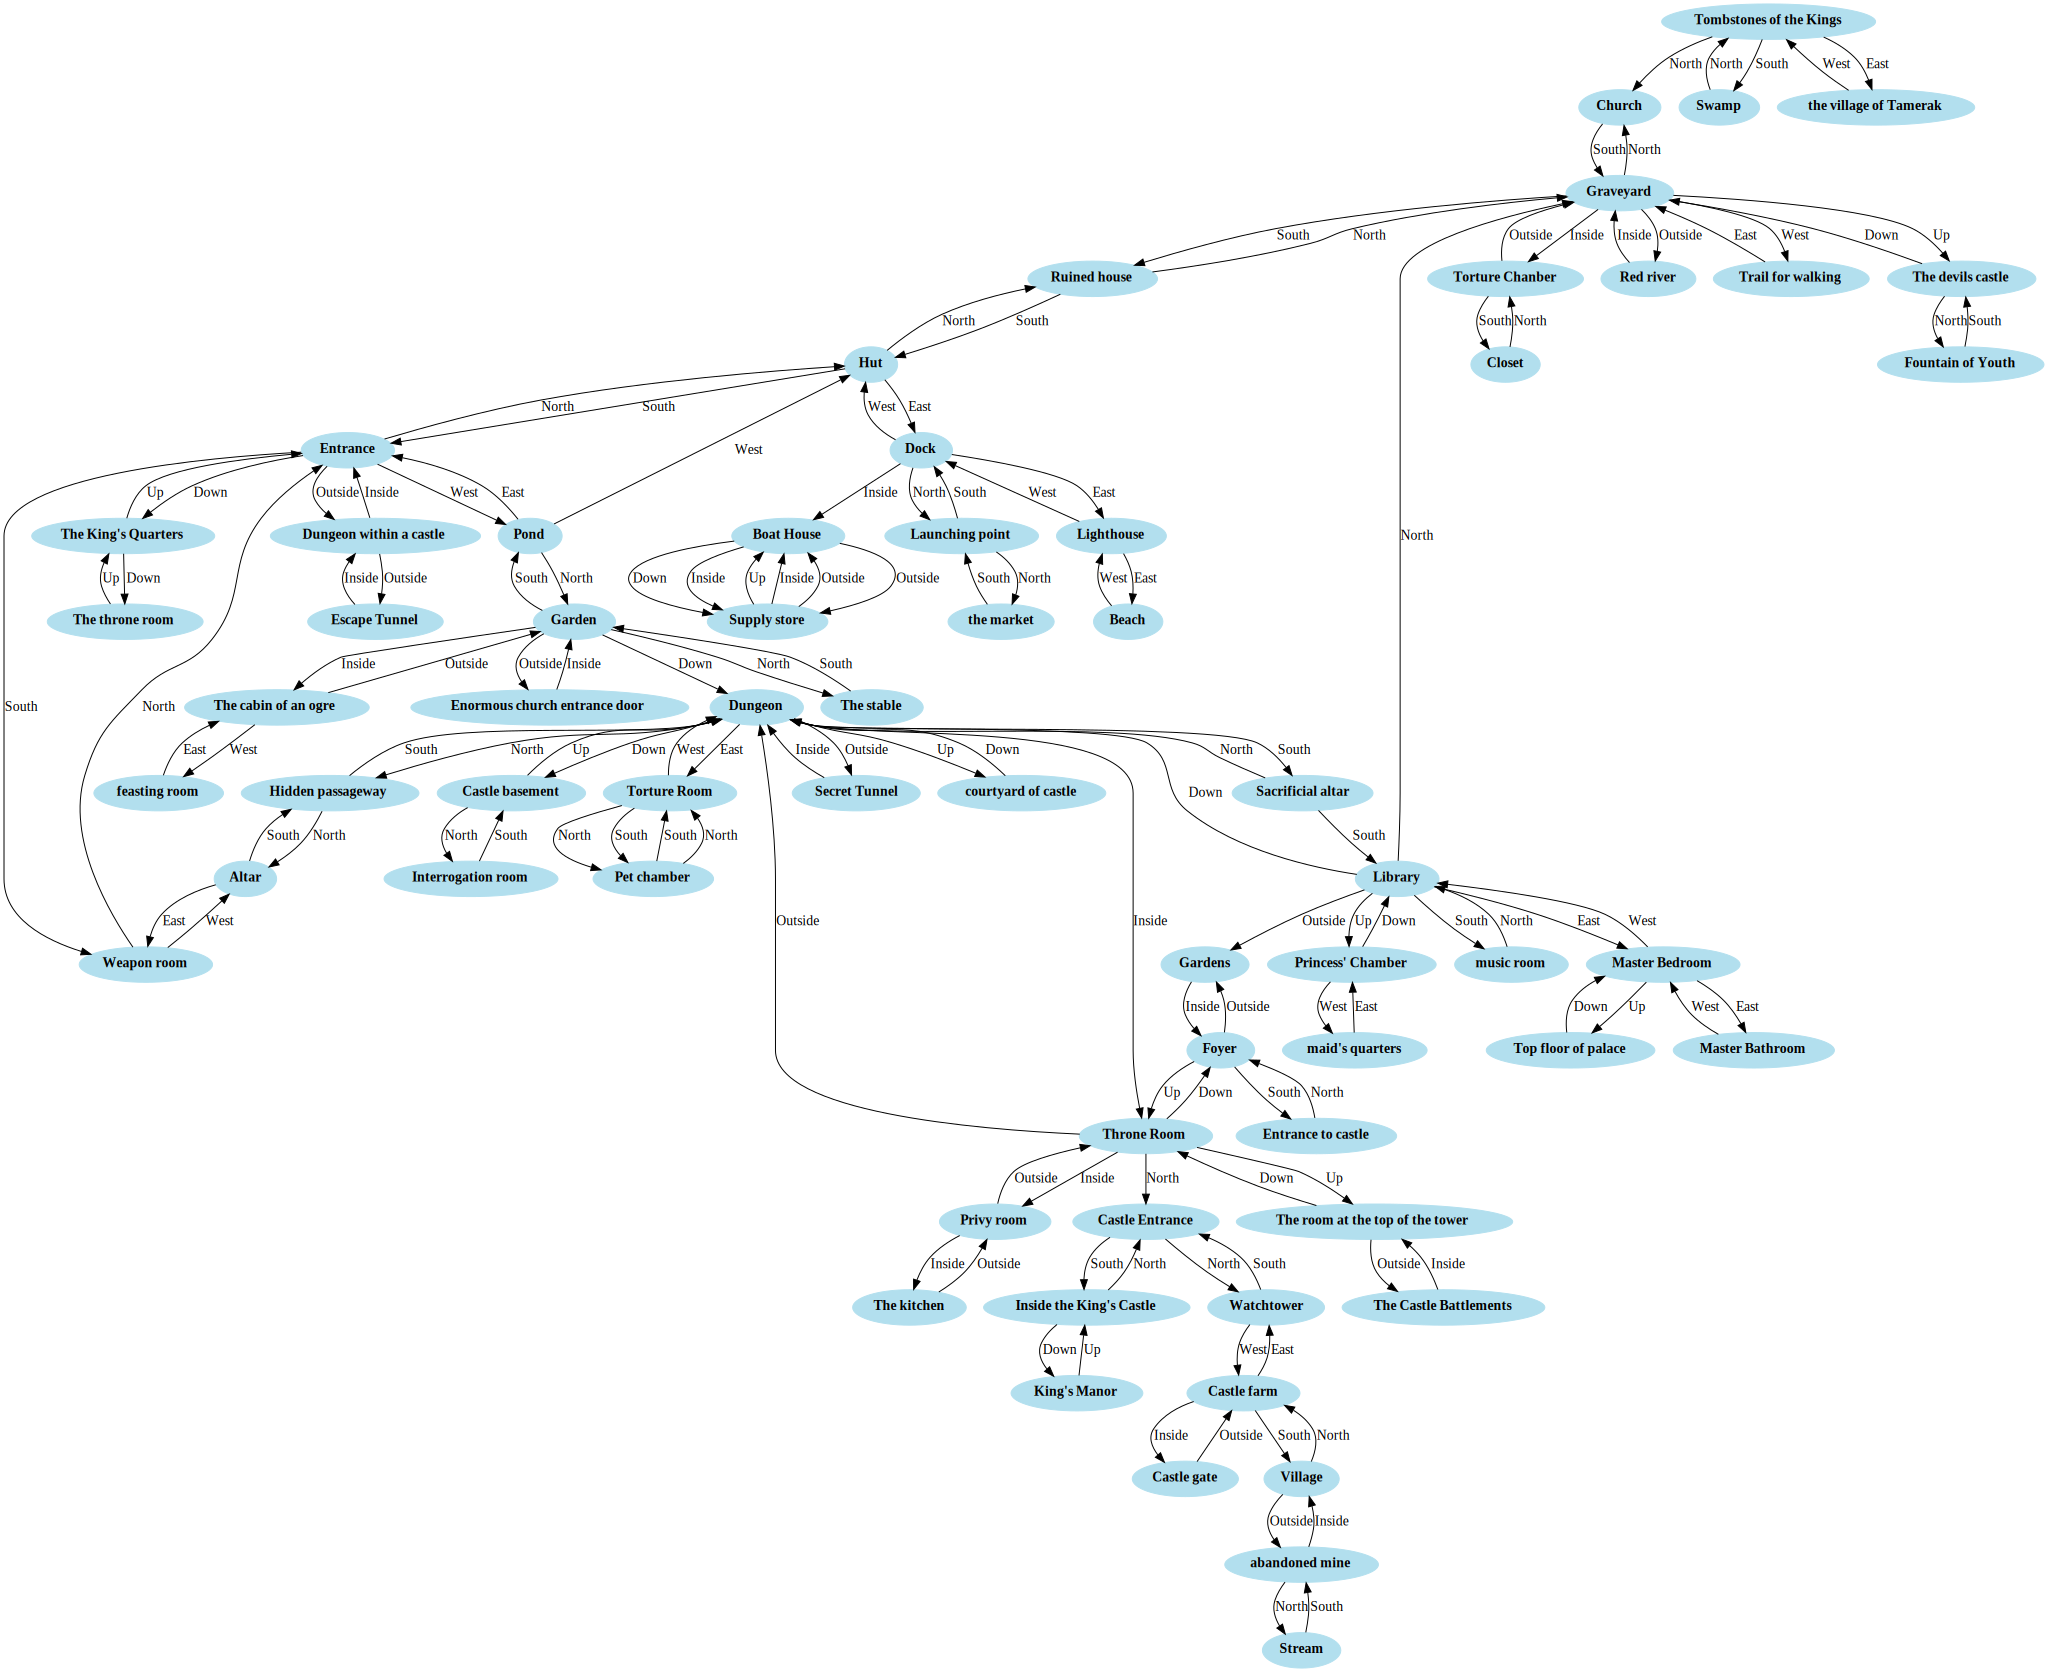

In [13]:
game, locations = build_game()

#!pip install graphviz
from graphviz import Digraph
from IPython.display import Image
import queue

def DFS(game, graph):
  """Do a depth-first-search traversal of the locations in the game
     starting at the start location, and create a GraphViz graph 
     to vizualize the connections between the locations, and the items
     that are located at each location."""
  start_location = game.curr_location
  frontier = queue.Queue()
  frontier.put(start_location)
  visited = {}
  visited[start_location.name] = True

  while not frontier.empty():
    current_location = frontier.get()
    game.curr_location = current_location
    name = current_location.name
    description = current_location.description
    items = current_location.items
#    items_html = describe_items(current_location)
    html = "<<b>%s</b>>" % (name)
#    html = "<<b>%s</b><br />%s<br />%s>" % (name, description, items_html)
    # Create a new node in the graph for this location
    graph.node(name, label=html)  

    connections = current_location.connections
    for direction in connections.keys():
      next_location = connections[direction]
      if not current_location.is_blocked(direction, game):
        # Create an edge between the current location and its successor
        graph.edge(name, next_location.name, label=direction.capitalize())
      else:
        # Create a dotted edge for connected locations that are blocked
        block_description = "%s\n%s" % (direction.capitalize(), current_location.get_block_description(direction))
        graph.edge(name, next_location.name, label=block_description, style="dotted")
      if not next_location.name in visited:
        visited[next_location.name] = True
        frontier.put(next_location)

def describe_items(location, print_commands=True):
    """Describe what objects are in the current location."""
    items_html = ""
    if len(location.items.keys()) > 0:
      items_html = "You see: "
    for item_name in location.items:
      item = location.items[item_name]
      items_html += item.description + ", "
      if print_commands:
        special_commands = item.get_commands()
        for cmd in special_commands:
          items_html += "<br/><i>%s</i>" % cmd
    return items_html

def save_to_drive(graph):
  from google.colab import drive
  drive.mount('/content/drive/')
  graph.render('/content/drive/My Drive/game-visualization', view=True)  

graph = Digraph(node_attr={'color': 'lightblue2', 'style': 'filled'})
game, locations = build_game()
DFS(game, graph)
#save_to_drive(graph)
graph


## Play Game

In [14]:
from IPython.display import display, Markdown

def game_loop():
  game, _ = build_game()
  parser = Parser(game)
  game.describe()

  command = ""
  while not (command.lower() == "exit" or command.lower == "q"):
    command = input(">")
    end_game = parser.parse_command(command)
    if end_game:
      return
#game_loop()
print('THE GAME HAS ENDED.')

THE GAME HAS ENDED.


# Annotation Helper functions

In [15]:
# Load a JSON file given a filename
# If the file doesn't exist, then return an empty dictionary instead
def load_json(filename):
    try:
        with open(filename, 'r') as f:
            return json.load(f)
    except FileNotFoundError:
        return {}

# Save a JSON file given a full path filename and a dictionary
# If the path doesn't exist, create the directories before saving the file.
def save_json(filename, data):
    if not os.path.exists(os.path.dirname(filename)):
        os.makedirs(os.path.dirname(filename))
    with open(filename, 'w') as f:
        json.dump(data, f, indent=4)

def get_simple_command_intents(command_name, command_description, filename, intent_json, num_examples=5):
  """ Elicit some different ways of saying simple commands like quit, save, and check inventory. """
  ways_of_saying_command = []
  if command_name in intent_json:
    ways_of_saying_command = intent_json[command_name]

  num_remining_to_collect = num_examples-len(ways_of_saying_command)
  if num_remining_to_collect > 0:
    print("Please give {how_many} ways that a player might ask {description} (one per line):".format(how_many=num_examples, description=command_description))
    for i in range(num_remining_to_collect):
      natural_language_command = input(">")
      if natural_language_command.lower().strip() == "skip":
        continue
      if natural_language_command == "":
        save_json(filename, intent_json)
        break
      command_info = {}
      command_info['natural_language_command'] = natural_language_command
      ways_of_saying_command.append(command_info)
      intent_json[command_name]  = ways_of_saying_command
      save_json(filename, intent_json)


def get_object_commands(game, locations, filename, intent_json, num_examples=5):
  """ Elicit some different ways of interacting with an object. """
  import random
  random_locations = list(locations.keys())
  random.shuffle(random_locations) 

  command_names = {"examine": "examine", "get": "get", "drop": "put down", "special": "do something special with"} 
  for command_name, command_description in command_names.items():
    ways_of_saying_command = []
    if command_name in intent_json:
      ways_of_saying_command = intent_json[command_name]
    num_remining_to_collect = num_examples-len(ways_of_saying_command)
    if num_remining_to_collect > 0:
      while num_remining_to_collect > 0:
        random_location = random_locations.pop()
        game.curr_location = locations[random_location]
        location_name = game.curr_location.name
        items = game.curr_location.items
        item_names = list(items.keys())
        item_name = ""
        for name in item_names:
          item = items[name]
          # Make sure that the item is gettable if the command is get or drop
          if (command_name == "get" or command_name == "drop"):
            if item.properties['gettable']:
              item_name = name
              break
          # If the command is examine or special, use any object
          else:
            item_name = name
            break

        if item_name == "":
          continue
        print("\n---")
        game.describe()
        print("\nHow could a player say that they want to {command_description} the {item_name}?".format(command_description=command_description.upper(), item_name=item_name.upper()))
        natural_language_command = input(">")
        if natural_language_command.lower().strip() == "skip":
          continue
        if natural_language_command == "":
            save_json(filename, intent_json)
            break
        command_info = {}
        command_info['location_name'] = location_name
        command_info['item_name'] = item_name
        command_info['natural_language_command'] = natural_language_command
        if command_name == "special":
          print("\nWhat would be a good ~2 word GAME COMMAND for {command}?".format(command=natural_language_command.upper()))
          game_command = input(">")
        else:
          game_command = command_name + ' ' + item_name
        command_info['game_command'] = game_command

        ways_of_saying_command.append(command_info)
        intent_json[command_name]  = ways_of_saying_command
        save_json(filename, intent_json)
        num_remining_to_collect -= 1



def get_direction_commands(game, locations, filename, intent_json, num_examples=5):
  """ Elicit some different ways of describing direction commands. """
  import random
  random_locations = list(locations.keys())
  random.shuffle(random_locations) 

  command_name = "direction"
  ways_of_saying_command = []
  if command_name in intent_json:
    ways_of_saying_command = intent_json[command_name]
  num_remining_to_collect = num_examples-len(ways_of_saying_command)
  if num_remining_to_collect > 0:
    while num_remining_to_collect > 0:
      random_location = random_locations.pop()
      game.curr_location = locations[random_location]
      location_name = game.curr_location.name
      if game.curr_location.description == "Desciption":
        continue
      if len(game.curr_location.connections) == 0:
        continue
      # check that there aren't multiple connections to the same location
      existing_locations = set()
      duplicates = False
      for dir, loc in game.curr_location.connections.items():
        loc_name = loc.name
        if loc_name in existing_locations:
          duplicates = True
        else:
          existing_locations.add(loc_name)
      if duplicates:
        continue
      print("\n---")
      game.describe()

      random_directions = list(game.curr_location.connections.keys())
      random.shuffle(random_directions)
      direction = random_directions[0]
      adjacent_location = game.curr_location.connections[direction]
      adjacent_location_name = adjacent_location.name
      print("How could a player say that they want to GO {direction}?".format(direction=direction.upper()))
      natural_language_command = input(">")
      if natural_language_command.lower().strip() == "skip":
        pass
      if natural_language_command == "":
          save_json(filename, intent_json)
          break
      command_info = {}
      command_info['location_name'] = location_name
      command_info['adjacent_location_name'] = adjacent_location_name
      command_info['direction'] = direction
      command_info['natural_language_command'] = natural_language_command
      command_info['game_command'] = "go " + direction
#      print("What should the game respond?")
#      response = input(">")
#      command_info['response'] = response
      ways_of_saying_command.append(command_info)
      intent_json[command_name]  = ways_of_saying_command
      save_json(filename, intent_json)
      num_remining_to_collect -= 1




def get_description_commands(game, locations, filename, intent_json, num_examples=5):
  """ Elicit some different ways of asking for more details about a location. """
  import random
  random_locations = list(locations.keys())
  random.shuffle(random_locations) 

  command_name = "redescribe"
  ways_of_saying_command = []
  if command_name in intent_json:
    ways_of_saying_command = intent_json[command_name]
  num_remining_to_collect = num_examples-len(ways_of_saying_command)
  if num_remining_to_collect > 0:
    while num_remining_to_collect > 0:
      random_location = random_locations.pop()
      game.curr_location = locations[random_location]
      location_name = game.curr_location.name
      if game.curr_location.description == "Desciption":
        continue
      print("\n---")
      game.describe_current_location()
#      game.describe()
      print("Imagine a player wants to ask for some details about the location {location} described above.  What might they ask?".format(location=location_name.upper()))
      natural_language_command = input(">")
      if natural_language_command.lower().strip() == "skip":
        continue
      if natural_language_command == "":
          save_json(filename, intent_json)
          break
      command_info = {}
      command_info['location_name'] = location_name
      command_info['natural_language_command'] = natural_language_command
#      print("What should the game respond?")
#      response = input(">")
#      command_info['response'] = response
      ways_of_saying_command.append(command_info)
      intent_json[command_name]  = ways_of_saying_command
      save_json(filename, intent_json)
      num_remining_to_collect -= 1



def get_sequence_commands(game, locations, filename, intent_json, max_seq_len=5, num_examples=5):
  """ Elicit a sequence of actions that a player might want to perform. """
  import random
  random_locations = list(locations.keys())
  random.shuffle(random_locations) 
  

  command_name = "sequence"
  ways_of_saying_command = []
  if command_name in intent_json:
    ways_of_saying_command = intent_json[command_name]
  num_remining_to_collect = num_examples-len(ways_of_saying_command)
  while num_remining_to_collect > 0:
    # Find a good starting location:
    while len(random_locations) > 0:
      random_location = random_locations.pop()
      game.curr_location = locations[random_location]
      location_name = game.curr_location.name
      if game.curr_location.description == "Desciption" or len(game.curr_location.connections) == 0 or len(game.curr_location.items) == 0:
        continue
      break
    print("\n---")
    game.describe()

    seq_len = random.randint(2, max_seq_len)
    base_commands = ["go", "go", "go", "examine", "examine", "get",  "get", "drop", "inventory", "save", "special"]
    random.shuffle(base_commands)
    command_sequence = []
    while(seq_len > 0 and len(base_commands) > 0):
      base_command = base_commands.pop()

      items = game.curr_location.items
      item_names = list(items.keys())
      item_name = ""
      for name in item_names:
        item = items[name]
        # Make sure that the item is gettable if the command is get or drop
        if (base_command == "get" or base_command == "drop"):
          if item.properties['gettable']:
            item_name = name
            break
        # If the command is examine or special, use any object
        else:
          item_name = name
          break
      if base_command == "go":
        direction, loc = list(game.curr_location.connections.items())[0]
        command = base_command + " " + direction
        command_sequence.append(command)
        seq_len -= 1
        game.curr_location = loc
      elif base_command == "examine" or base_command == "get" or base_command == "drop" or base_command == "special":
        if item_name == "":
          continue
        command = base_command + " " + item_name
        command_sequence.append(command)
        seq_len -= 1
      else:
        command_sequence.append(base_command)
        seq_len -= 1

    print("\nImagine a player wants to execute the following sequence of actions starting at the location {location}:".format(location=location_name.upper()))
    print("\n".join(command_sequence))
    print("How could they describe that whole sequence all at once?")
    natural_language_command = input(">")
    if natural_language_command.lower().strip() == "skip":
      continue
    if natural_language_command == "":
        save_json(filename, intent_json)
        continue
    command_info = {}
    command_info['location_name'] = location_name
    command_info['command_sequence'] = command_sequence
    command_info['natural_language_command'] = natural_language_command
  #      print("What should the game respond?")
  #      response = input(">")
  #      command_info['response'] = response
    ways_of_saying_command.append(command_info)
    intent_json[command_name]  = ways_of_saying_command
    save_json(filename, intent_json)
    num_remining_to_collect -= 1




# Annotate data

In [ ]:

from google.colab import drive
drive.mount('/content/drive')
filename = '/content/drive/My Drive/CIS 700/HW2-intent_data.json'
intent_json = load_json(filename)

get_simple_command_intents("quit", "to quit the game", filename, intent_json, num_examples=5)
get_simple_command_intents("save", "to save their progress in the game", filename, intent_json, num_examples=3)
get_simple_command_intents("inventory", "to check their inventory", filename, intent_json, num_examples=5)

game, locations = build_game()
get_direction_commands(game, locations, filename, intent_json, num_examples=15)
get_object_commands(game, locations, filename, intent_json, num_examples=10)
get_sequence_commands(game, locations, filename, intent_json, max_seq_len=5, num_examples=5)
get_description_commands(game, locations, filename, intent_json, num_examples=5)


print("You are done annotating!")
print("Your annnotations have been saved on your Google drive at {filename}".format(filename=filename))
print("Please upload this file to Gradescope.")

# START HERE: Create a Prompt for Intent Detection

Here is an example of one way that we can use the data that you annotated in order to perform intent detection with the OpenAI API.  We will perform "few shot learning" by creating a prompt that includes each of the natural language commands that you created, followed by the intent, followed by a "stop sequence".  Here's a short sample of what our prompt looks like:

```
gather up the stones
get
###
go to the market
direction
###
collect a lily pad from the water
get
###
take a look at the lock's mechanism
examine
###
Is there any light in the dungeon?
redescribe
###
look at the food and head east
sequence
###
```

We will append a user command to the prompt, and then have OpenAI perform a completion.  If it has successfully learned the pattern in our prompt then it should predict one of the intents. For example if the user inputs `take the sword from its scabbard` then OpenAI should predict the intent `get`.


In [ ]:
import random

intent_json = load_json(filename)
intents = []

prompt = ""

for intent in intent_json:
  for command_info in intent_json[intent]:
    natural_language_command = command_info['natural_language_command'] 
    intents.append((natural_language_command, intent))

random.shuffle(intents)
for natural_language_command, intent in intents:
  prompt += natural_language_command + "\n"
  prompt += intent  + "\n"
  prompt += '###'  + "\n"

In [ ]:
print(prompt)

If you've got access to the OpenAI API, then you can use it to generate ideas for artwork.  You'll need to enter your OpenAI API key, which you can find [here](https://beta.openai.com/account/api-keys).

In [ ]:
from getpass import getpass
print('Enter OpenAI API key:')
openai_api_key = getpass()

In [ ]:
%%capture
!pip install openai

In [ ]:
import openai
openai.api_key = openai_api_key

def get_player_intent(command):
  response = openai.Completion.create(
    engine="davinci",
    prompt=prompt + command + "\n",
    temperature=0.7,
    max_tokens=64,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0,
    stop=["###"]
  )
  return response['choices'][0]['text']

In [ ]:
command = "take the sword from its scabbard"
while command != "":
  command = input("> ")
  print(get_player_intent(command))

# Evaluate your prompt-based model

How well does your propt based model do?  Let's write an evaluation function for it.

I have compiled the data from all of the students' intent annotations into training/dev/test files

In [ ]:
!wget https://raw.githubusercontent.com/interactive-fiction-class/interactive-fiction-class-data/master/intent/intent_training.jsonl
!wget https://raw.githubusercontent.com/interactive-fiction-class/interactive-fiction-class-data/master/intent/intent_dev.jsonl
!wget https://raw.githubusercontent.com/interactive-fiction-class/interactive-fiction-class-data/master/intent/intent_test.jsonl


In [18]:
!head intent_test.jsonl

{"location_name": "Quicksand Pit", "natural_language_command": "let the shrub be", "intent": "drop", "game_command": "drop shrub"}
{"location_name": "Watchtower", "natural_language_command": "go to the farm", "intent": "direction", "game_command": "go west"}
{"location_name": "Bed Chambers", "natural_language_command": "grab ornament", "intent": "get", "game_command": "get ornament"}
{"location_name": "the well", "natural_language_command": "exit game", "intent": "quit", "game_command": "quit"}
{"location_name": "Collapsed West Wing", "natural_language_command": "save", "intent": "save", "game_command": "save"}
{"location_name": "Gallery", "natural_language_command": "head to north", "intent": "direction", "game_command": "go north"}
{"location_name": "Gardenia Hill", "natural_language_command": "save my progress", "intent": "save", "game_command": "save"}
{"location_name": "Main hallway", "natural_language_command": "Descend into the dungeon", "intent": "direction", "game_command": "g

In [ ]:
def evaluate_intent_determination():
  pass

# Fine-Tune a Model

Next, we will **fine-tune** GPT to perform our task.

# Format Data for Fine-Tuning 

Below, I show how to create data to fine-tune OpenAI.  The OpenAI API documentation has a [guide to fine-tuning models](https://beta.openai.com/docs/guides/fine-tuning) that you should read.   The basic format of fine-tuning data is a JSONL file (one JSON object per line) with two key-value pairs: `prompt:` and `completion:`.

```
{"prompt": "<prompt text>", "completion": "<ideal generated text>"}
{"prompt": "<prompt text>", "completion": "<ideal generated text>"}
{"prompt": "<prompt text>", "completion": "<ideal generated text>"}
...
```

In the code below, I'll extract a prompt that contains the `natural_language_command` variable from the intent dtermination data, and I'll have the completion be the  `intent`.

In [ ]:

def create_intent_determination_finetuning_data_v1(input_filename='intent_test.jsonl', filename='fine_tuning_intent_determination-1.jsonl'):
  fine_tuning_data = []
  for category in categories:
    rooms = rooms_by_category[category]
    for room_id in rooms:
      data = {}
      prompt, completion = get_room_description(room_id, rooms_by_id, light_environment)
      data['prompt'] = prompt
      data['completion'] = completion
      print(prompt, end="")
      print(completion)
      fine_tuning_data.append(data)

  with open(filename, 'w') as out:
    for data in fine_tuning_data:
        out.write(json.dumps(data))
        out.write('\n')

create_intent_determination_finetuning_data_v1()

# Fine-tune GPT3 with the OpenAI API

Next, we'll perform fine-tuning with this data using OpenAI. 

In [ ]:
%%capture
!pip install --upgrade openai
!pip install jsonlines

Once you've got access to the OpenAI API, you can find your OpenAI API key [here](https://beta.openai.com/account/api-keys).

In [ ]:
import os
import openai

print('Enter OpenAI API key:')
openai.api_key = input()

os.environ['OPENAI_API_KEY']=openai.api_key

In [ ]:
!head fine_tuning_intent_determination-1.jsonl

Next, we'll make the fine tuning API call via the command line.  Here the -m argument gives the model.  There are 4 sizes of GPT3 models.  They go in alphabetical order from smallest to largest.
* Ada 
* Baddage
* Currie
* Davinci

The models as the model sizes increase, so does their quality and their cost.  Davinci is the highest quality and highest cost model.  I recommend starting by fine-tuning smaller models to debug your code first so that you don't rack up costs.


In [ ]:
!openai api fine_tunes.create -t fine_tuning_intent_determination-1.jsonl -m baddage

You should copy down the fine-tune numbers which look like this:

```
Created fine-tune: ft-VzQpTwfnWAzDXNKgPTFtiZg2

[2022-01-21 23:22:47] Uploaded model: curie:ft-ccb-lab-members-2022-01-21-23-22-46
```

If you forget to write it down, you can list your fine-tuned runs and models this way. These model names aren't mneumonic, so it is probably a good idea to make a note on what your model's inputs and outputs are. 

In [ ]:
!openai api fine_tunes.list

You can run your fine tuned model in the OpenAI Playground.  After the model is finished finetuning you'll find it in the Engine dropdown menu.  

In [ ]:
def get_intent_ft_1(command, finetuned_model):
  response = openai.Completion.create(
      model=finetuned_model,
      prompt="Command: {command}\nIntent: ".format(
          command=command.lower()
      ),
      temperature=0.7,
      max_tokens=64,
      top_p=1,
      frequency_penalty=0,
      presence_penalty=0,
      stop=["###"]
      )
  return response['choices'][0]['text']

# Replace with your model's name
finetuned_model = "curie:ft-ccb-lab-members-2022-01-21-23-22-46"
command = "take the sword from its scabbard"
while command != "":
  command = input("> ")
  print(get_intent_ft_1(command))



## Evalaution 

Let's evaluate the model again - how well does it do against the prompt-based model?

In [ ]:
def evaluate_intent_determination():
  pass

# Extensions

If you've got time, try the following:
* Experiment with the 4 different sizes of models, and compare their performance on intent determination when they are prompt-based v. fine-tuned.
* Instead of trying to predict the `intent` field from our intent determination data try to predict the `game_command` field. (You will probably want to include the current game location information in your fine tuning - like the setting description, the items and the locations).